# What is this about?

This Jupyter notebook is meant to explore the data collected from the **Stack Overflow Annual Developer Survey** (2021), with particular focus on the developers compensation. 

The dataset can be downloaded [here](https://insights.stackoverflow.com/survey).

All the compensations are mapped to Euros thanks to this [Free Currency Rates API](https://github.com/fawazahmed0/currency-api).

### Init (import libraries and define common functions)

In [ ]:
import sys
import pandas as pd
import json
from urllib.request import urlopen
from IPython.display import display, Markdown

def exists(name):
    return name in locals() or name in globals()

# initialize the conversion rates only once even if this cell gets executed multiple times
if not exists('currencies'):
    currencies = {}
else:
    print('Keeping the existing cache of currency conversion rates')

"""One euro is equivalent to X in the other currency"""
def euro_equivalent(c):
    global currencies
    c = c.lower()
    if c in currencies:
        return currencies[c]
    else:
        try:
            url = "https://cdn.jsdelivr.net/gh/fawazahmed0/currency-api@1/latest/currencies/eur/%s.json" % c
            res = urlopen(url)
            data = json.loads(res.read())
            conversion = data[c]
            currencies[c] = conversion
#             print("New currency: %s (%f)" % (c, conversion))
            return conversion
        except:
            return sys.float_info.max
    
"""Multiply the salary X times to get the yearly compensation"""
def yearly_multiplier(freq):
    return 48 if freq == 'Weekly' else 12 if freq == 'Monthly' else 1

"""Remove the outliers from a dataframe based on the values of a single column.
Keep only the rows that, for the specified column, have values in between the [qlow, qhigh] quantiles.
"""
def remove_outliers(df, column, qlow, qhigh):
    low = df[column].quantile(qlow)
    high = df[column].quantile(qhigh)
#     print('Keeping only %s in [%f, %f]' % (column, low, high))
    return df[(df[column] < high) & (df[column] > low)]

"""Print markdown in output"""
def print_md(s):
    display(Markdown(s))


### Read and cleanup the dataset (it takes a while the first time, to download all the currency rates)

In [ ]:
df = pd.read_csv (r'./resources/developer_survey_2021/survey_results_public.csv', 
                  usecols=['Country', 'Currency', 'CompTotal', 'CompFreq', 'YearsCodePro', 
                           'OrgSize', 'Employment', 'MainBranch', 'LanguageHaveWorkedWith'])
initsize = df.size
print("Size after import: %f" % initsize)

# clean it up
df = df.dropna()
print("Size after NA filtering: %f (-%s wrt import)" % (df.size, ((initsize - df.size) / initsize)))

# # Uncomment these lines to keep only compensations that are reported as yearly total. 
# # This could, in some case, improve the reliability of the data (see Appendix)
# df = df[df.CompFreq == 'Yearly']
# print("Size after compensation filtering: %f (-%s wrt import)" % (df.size, ((initsize - df.size) / initsize)))

# Remove unknown organization size
df = df[~df.OrgSize.str.startswith('I don')]
print("Size after org size filtering: %f (-%s wrt import)" % (df.size, ((initsize - df.size) / initsize)))

# Polish organization size data and make it usable
# The 'OrgSizeCategory' is assigned based on the official EU classification 
# see https://en.wikipedia.org/wiki/Small_and_medium-sized_enterprises
df['OrgSize'] = df['OrgSize'].map(lambda v: '1 ' if v.startswith("Just me") else v)
df['OrgSizeMax'] = df.apply(lambda row: int(row['OrgSize'][:row['OrgSize'].find(' ')].replace(',','')), axis=1)
df['OrgSizeCategory'] = df['OrgSizeMax'].map(lambda v: 'Micro' if v < 10 else 'Small' if v < 50 else 'Medium' if v < 250 else 'Large')


# Keep only full-time employed programmers
df = df[df.Employment == 'Employed full-time']
df = df[df.MainBranch == 'I am a developer by profession']
print("Size after employment filtering: %f (-%s wrt import)" % (df.size, ((initsize - df.size) / initsize)))

# Convert the years of professional coding to a number
df['YearsCodePro'] = df['YearsCodePro'].map(lambda v: 0 if v == 'Less than 1 year' else 55 if v == 'More than 50 years' else int(v))

# Append a semi-colon to the list so that searching by sub-string is consistent
# i.e. avoid matching 'Java' in 'JavaScript': look for 'Java;' instead
df['LanguageHaveWorkedWith'] = df['LanguageHaveWorkedWith'].map(lambda l: l + ';')

# calculate yearly compensation in EUR
df['Currency'] = df['Currency'].map(lambda s: str(s)[:3])
df['EuroYearlyComp'] = df.apply(lambda row: row['CompTotal'] * yearly_multiplier(row['CompFreq']) / euro_equivalent(row['Currency']), axis=1)

# display(df)

## General comparison

Yearly compensation ranges showed as boxplots, by country. Outliers are not shown.

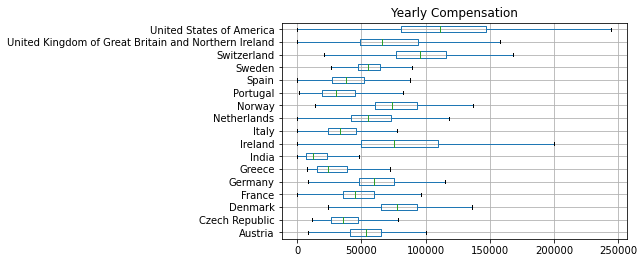

In [43]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# Process only these countries. Leave it empty to process all the countries
countries = ['Italy', 'Germany', 'Spain', 'France', 'United States of America', 
             'Switzerland', 'United Kingdom of Great Britain and Northern Ireland', 'Austria', 'Portugal',
             'Sweden', 'Norway', 'Denmark', 'Greece', 'Czech Republic', 'Ireland', 'Netherlands', 'India']

data = df[df.Country.isin(countries)] if countries else df

print_md("Yearly compensation ranges showed as boxplots, by country. Outliers are not shown.")

ax = data.boxplot(by='Country', column=['EuroYearlyComp'], showfliers=False, vert=False)
ax.set_xlabel("")
plt.title("Yearly Compensation")
plt.suptitle("")
plt.show()

## By Country

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# Ignore countries that have less than 'min_datapoints' records available
min_datapoints = 500
# Process only these countries. Leave it empty to process all the countries
countries = ['Italy', 'Germany', 'Spain', 'France', 'United States of America', 
             'Switzerland', 'United Kingdom of Great Britain and Northern Ireland', 'Austria', 'Portugal',
             'Sweden', 'Norway', 'Denmark', 'Greece', 'Czech Republic', 'Ireland', 'Netherlands', 'India']
# countries = ['Italy']

languages = ['Python', 'Java', 'Kotlin', 'C', 'C++', 'Scala', 'C#', 'Go', 'JavaScript', 'TypeScript', 
             'Groovy', 'Erlang', 'HTML/CSS', 'Bash/Shell', 'Assembly', 'Node.js', 'Clojure', 'Delphi', 
             'Haskell', 'R', 'Dart', 'Matlab', 'PowerShell', 'PHP', 'Rust', 'Ruby', 'Perl']

def country_report(name, df):
    print_md("## %s" % name)
    print_md("#### Yearly compensation")
    
    print_md('General stats on yearly compensation in %s' % name)
    quantiles = pd.DataFrame([[q, df['EuroYearlyComp'].quantile(q)] for q in [.05, .1, .25, .5, .75, .9, .95]], 
                         columns = ['Quantile', 'Yearly Compensation'])
    print_md(quantiles.to_markdown(index=False))
    
    print_md('Compensation vs years of professional coding')
    df['YearsCodeProBin'] = df['YearsCodePro'].map(lambda v: int(v / 10))
    df.boxplot(by='YearsCodeProBin', column=['EuroYearlyComp'], showfliers=False)
    plt.title("Yearly compensation per decade of pro coding")
    plt.suptitle("")
    plt.show()
    
    points = remove_outliers(group,'EuroYearlyComp', .05, .95)
    
    print_md("#### By organization size")
    print_md("Yearly compensation vs years of professional coding, in %s. Unaggregated data (without ouliers)" % name)
    bysize = df.groupby('OrgSizeCategory')
    fig = plt.figure()
    for orgsize, data in bysize:
        plt.plot(data['YearsCodePro'], data['EuroYearlyComp'], marker=".", linestyle="", label=orgsize, alpha=.2)
        plt.axis((0, 60, 0, 200000))
    plt.legend()
    plt.show()
    
    print_md('Compensation vs company size')
    df.boxplot(by='OrgSizeCategory', column=['EuroYearlyComp'], showfliers=False)
    plt.title("Yearly compensation per organization size")
    plt.suptitle("")
    plt.show()
    
    print_md("#### By language")
    print_md("Yearly compensation by programming language in %s." % name)
    langframes = []
    for lang in languages:
        langdf = df[df['LanguageHaveWorkedWith'].str.contains(lang + ';', regex=False)].copy()
        if langdf.size < 100:
            continue
        langdf['Language'] = lang
        langframes.append(langdf[['Language', 'EuroYearlyComp']])
    pd.concat(langframes).boxplot(by='Language', column=['EuroYearlyComp'], showfliers=False, vert=False)
    plt.title("Yearly compensation per language")
    plt.suptitle("")
    plt.show()


data = df[df.Country.isin(countries)] if countries else df

# plt.rcParams["figure.figsize"] = (5,3)
groups = data.groupby('Country')
for name, group in groups:
    if group.size > min_datapoints: # ignore countries with few data points
        country_report(name, group)



# Appendix

## Are monthly and weekly compensation reliable?

### The outliers

Monthly and weekly compensation appear to be often out of scale. This could happen, for example, if by mistake a yearly 
salary is marked as monthly or weekly.


In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

adf = pd.read_csv (r'./resources/developer_survey_2021/survey_results_public.csv', 
                  usecols=['Country', 'Currency', 'CompTotal', 'CompFreq'])

# remove NA
adf = adf.dropna()

# calculate yearly compensation in EUR
adf['Currency'] = adf['Currency'].map(lambda s: str(s)[:3])
adf['EuroYearlyComp'] = adf.apply(lambda row: row['CompTotal'] * yearly_multiplier(row['CompFreq']) / euro_equivalent(row['Currency']), axis=1)

with_outliers = adf.groupby('CompFreq').size()

frames = []
for country, data in adf.groupby('Country'):
    frames.append(remove_outliers(data, 'EuroYearlyComp', .05, .95))
filtered = pd.concat(frames)

without_outliers = filtered.groupby('CompFreq').size()

result = pd.concat([with_outliers, without_outliers], axis=1, join="inner")
result['Removal rate'] = (result[0] - result[1]) / result[0]

display(result.rename(columns={0: "With outliers", 1: "Without outliers"}))

print_md("If we remove, for each country, the compensations below the .05 quantile and beyond the .95 quantile" + 
        "we end up removing a good deal of the weekly and monthly data.")

### Isn't monthly compensation too low?

It seems also that monthly compensation is reported to be generally, and sometimes significantly, lower than yearly 
compensation. 

This is well visible esapecially in Western and Central European countries, like Austria, Belgium, France, Germany, Greece, Italy, Netherlands, Portugal, Spain, Switzerland.

A possible explaination, to be verified, could be that the fiscal policy in these countries makes it harder to know 
or understand the exact compensation value before taxes, because taxes are subtracted upfront.

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

adf = pd.read_csv (r'./resources/developer_survey_2021/survey_results_public.csv', 
                  usecols=['Country', 'Currency', 'CompTotal', 'CompFreq', 'YearsCodePro'])

# remove NA
adf = adf.dropna()

adf['YearsCodePro'] = adf['YearsCodePro'].map(lambda v: 0 if v == 'Less than 1 year' else 55 if v == 'More than 50 years' else int(v))

# calculate yearly compensation in EUR
adf['Currency'] = adf['Currency'].map(lambda s: str(s)[:3])
adf['EuroYearlyComp'] = adf.apply(lambda row: row['CompTotal'] * yearly_multiplier(row['CompFreq']) / euro_equivalent(row['Currency']), axis=1)

print_md("The graphs below show, for each country (excluding those with few data points) the yearly" +
         " compensation in Euros vs the years of professional coding.")
print_md("The weekly/monthly/yearly compensation have different color.")
print_md("The lines are the linear regression, for each reported compensation frequency, that show the" + 
         " expected compensation increases with the years of professional coding")

for country, cdata in adf.groupby('Country'):
    cdata = remove_outliers(cdata, 'EuroYearlyComp', .05, .9)
    if cdata.size < 1000: # ignore countries with few data points
        continue
    print_md("#### %s" % country)
    fig = plt.figure()
    for freq, fdata in cdata.groupby('CompFreq'):
        if fdata.size < 150:
            continue
        plt.plot(fdata['YearsCodePro'], fdata['EuroYearlyComp'], marker=".", linestyle="", label=freq, alpha=.3)
        # linear regression
        linear_regressor = LinearRegression() 
        X = fdata['YearsCodePro'].values.reshape(-1, 1)
        Y = fdata['EuroYearlyComp'].values.reshape(-1, 1)
        linear_regressor.fit(X, Y)
        Y_pred = linear_regressor.predict(X)
        plt.plot(X, Y_pred, label=freq)
    plt.legend()
    plt.show()

### So? Are they reliable?

Probably they are not very reliable in most cases, and especially if we are looking at Western and Central European countries. In fact, for many countries, the monthly and weekly data seem to add more noise than valuable information.

However the number of datapoints marked as monthly/weekly makes around the 50% of the available dataset, and there are countries where the monthly data outnumbers greatly the yearly data. In these cases removing the monthly/weekly data might not be a good idea.

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

adf = pd.read_csv (r'./resources/developer_survey_2021/survey_results_public.csv', 
                  usecols=['Country', 'CompFreq'])

display(adf.groupby(['CompFreq']).size())

world = []
for country, data in adf.groupby('Country'):
    if data.size < 1000: # ignore countries with few data points
        continue
    print_md('#### %s' % country)
    data['CompFreq'].hist()
    plt.show()
